<a href="https://colab.research.google.com/github/berviantoleo/machine-learning-experiment/blob/master/Submission_3_Image_Classification_Deployment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Created by: Bervianto Leo Pratama            

# Online Products

Source dataset: https://cvgl.stanford.edu/projects/lifted_struct/

The research document for initial research: https://cvgl.stanford.edu/papers/song_cvpr16.pdf

Another reference about the dataset: https://www.tensorflow.org/datasets/catalog/stanford_online_products


In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

## Data Preparation

In [ ]:
import tensorflow_datasets as tfds

dl_manager = tfds.download.DownloadManager(download_dir='stanford_online_products')
dataset_dir = dl_manager.download_and_extract('ftp://cs.stanford.edu/cs/cvgl/Stanford_Online_Products.zip')


In [ ]:
import os
dir_set = os.path.join(dataset_dir, 'Stanford_Online_Products')
os.listdir(dir_set)

['stapler_final.txt',
 'chair_final',
 'coffee_maker_final.txt',
 'coffee_maker_final',
 'mug_final',
 'fan_final',
 'bicycle_final.txt',
 'kettle_final.txt',
 'Ebay_test.txt',
 'bicycle_final',
 'toaster_final.txt',
 'chair_final.txt',
 'sofa_final',
 'lamp_final',
 'sofa_final.txt',
 'table_final.txt',
 'LICENSE',
 'stapler_final',
 'lamp_final.txt',
 'Ebay_final.txt',
 'cabinet_final.txt',
 'README',
 'kettle_final',
 'toaster_final',
 'Ebay_info.txt',
 'cabinet_final',
 'Ebay_train.txt',
 'mug_final.txt',
 'fan_final.txt',
 'table_final']

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255,
    zoom_range=0.2,
    shear_range=0.2,
    rotation_range=20,
    fill_mode='nearest',
    horizontal_flip=True,
    validation_split=0.2) # set validation split

In [ ]:
train_generator = train_datagen.flow_from_directory(
      dir_set,
      target_size=(224, 224),
      batch_size=64,
      classes=['bicycle_final', 'cabinet_final', 'coffee_maker_final'],
      class_mode='categorical',
      subset='training') # set as training data
validation_generator = train_datagen.flow_from_directory(
      dir_set, # same directory as training data
      target_size=(224, 224),
      batch_size=64,
      classes=['bicycle_final', 'cabinet_final', 'coffee_maker_final'],
      class_mode='categorical',
      subset='validation')

Found 24065 images belonging to 3 classes.
Found 6014 images belonging to 3 classes.


## Define Callback


In [ ]:
class myCallback(tf.keras.callbacks.Callback):
   def on_epoch_end(self, epoch, logs={}):
      if(logs.get('accuracy') >= 0.92 and logs.get('val_accuracy') >= 0.92):
          print("\nAkurasi telah mencapai >=92%!")
          self.model.stop_training = True
callbacks = myCallback()

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=15, min_lr=0.00001, verbose=2)

## Model Preparation

In [ ]:
from keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Input
base_model = VGG16(include_top=False, input_tensor=Input(shape=(224, 224, 3)))
base_model.trainable = False
base_model.summary()

58892288/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
______________________________________________________________

In [ ]:
model = tf.keras.models.Sequential([
    base_model,  
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')   
])

In [ ]:
model.compile(optimizer=tf.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics = ['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 512)               12845568  
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 771       
Total params: 27,692,355
Trainable params: 12,977,667
Non-trainable params: 14,714,688
___________________________________

## Model Training

In [ ]:
#@title
with tf.device('/device:GPU:0'):
  history = model.fit(train_generator,
                   validation_data=validation_generator,
                   epochs=500,
                   batch_size=128,
                   callbacks=[callbacks, reduce_lr],
                   steps_per_epoch=5,
                   verbose=2)

Epoch 1/500
5/5 - 81s - loss: 6.5270 - accuracy: 0.3219 - val_loss: 2.6657 - val_accuracy: 0.5371
Epoch 2/500
5/5 - 78s - loss: 2.8040 - accuracy: 0.5344 - val_loss: 0.6168 - val_accuracy: 0.5961
Epoch 3/500
5/5 - 78s - loss: 1.1720 - accuracy: 0.5562 - val_loss: 0.4424 - val_accuracy: 0.8557
Epoch 4/500
5/5 - 78s - loss: 0.6855 - accuracy: 0.7281 - val_loss: 0.4086 - val_accuracy: 0.8375
Epoch 5/500
5/5 - 78s - loss: 0.5497 - accuracy: 0.7906 - val_loss: 0.3559 - val_accuracy: 0.8748
Epoch 6/500
5/5 - 78s - loss: 0.4066 - accuracy: 0.8438 - val_loss: 0.3378 - val_accuracy: 0.8770
Epoch 7/500
5/5 - 78s - loss: 0.5237 - accuracy: 0.7875 - val_loss: 0.3709 - val_accuracy: 0.8700
Epoch 8/500
5/5 - 78s - loss: 0.4209 - accuracy: 0.8188 - val_loss: 0.3047 - val_accuracy: 0.8903
Epoch 9/500
5/5 - 78s - loss: 0.2730 - accuracy: 0.8969 - val_loss: 0.3161 - val_accuracy: 0.8818
Epoch 10/500
5/5 - 78s - loss: 0.3177 - accuracy: 0.8719 - val_loss: 0.2843 - val_accuracy: 0.8947
Epoch 11/500
5/5 - 

## Model Result Summary

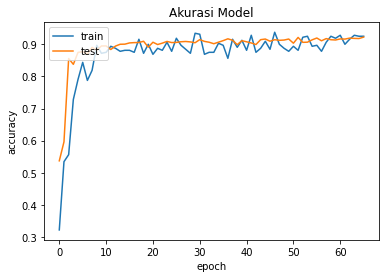

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Akurasi Model')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

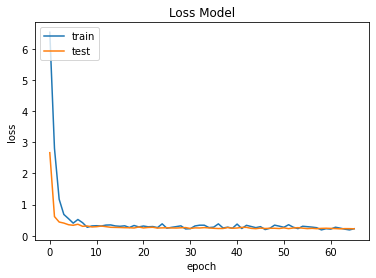

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Save Model to TFLite


In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


INFO:tensorflow:Assets written to: /tmp/tmpn5g0oz5c/assets


INFO:tensorflow:Assets written to: /tmp/tmpn5g0oz5c/assets


In [ ]:
with tf.io.gfile.GFile('image-model.tflite', 'wb') as f:
  f.write(tflite_model)